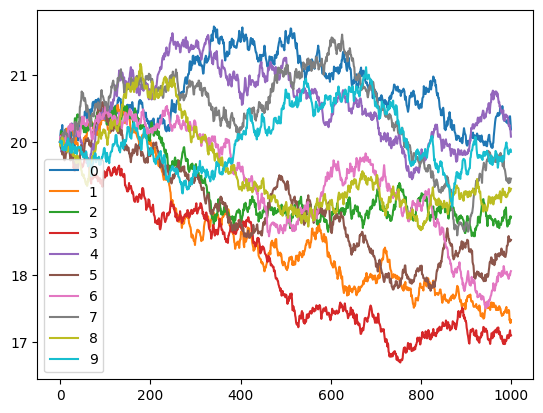

In [9]:
import numpy as np
import pandas as pd


def get_price_path(n=1_000, mu=0, sigma=.0025, s0=20):
    noises = np.random.normal(0, 1, n)
    s = [s0]
    for t in range(1, n):
        s.append(
            s[-1]*(1+sigma*noises[t])
        )
        
    s = pd.Series(s)
    return s

def get_price_paths(m=10):
    return pd.DataFrame([get_price_path() for _ in range(m)])



get_price_paths().T.plot();

In [10]:
# def tst():
#     effective_slippage_pct = pd.Series({
#         1: .05,
#         10: .05,
#         10_000: .05,
#         100_000: .059,
#         500_000: .097,
#         6_500_000: .64,
#         10_000_000: 1.33,
#         : 3.67
#     })
#     return effective_slippage_pct

# tst().plot()

In [251]:
import matplotlib.pyplot as plt

def arb_input_given_prices(p0, p1, L, gamma):
    """
    The amount of token that must be put in to
    achieve the new price.
    
    If p1<p0, then this gives the amount of token0 to put into the pool.
    If p1>p0, then this gives the amount of token1 to put into the pool.
    """
    
    if p1 < p0:
        return np.sqrt(L)*(np.sqrt(1/p1)-np.sqrt(1/p0)) / (1-gamma)
    else:
        return np.sqrt(L)*(np.sqrt(p1)-np.sqrt(p0)) / (1-gamma)
    
def arb_output_given_prices(p0, p1, L, gamma):
    if p0 < p1:
        return -np.sqrt(L)*(np.sqrt(1/p1)-np.sqrt(1/p0))
    else:
        return -np.sqrt(L)*(np.sqrt(p1)-np.sqrt(p0)) / (1-gamma)

def avg_execution_price_given_prices(p0, p1, gamma):
    """
    Average execution price for trading from p0 to p1,
    including LP fees.    
    """
    
    mult = (1-gamma) if p0>p1 else 1/(1-gamma)
    return mult*(
        np.sqrt(p1)-np.sqrt(p0)
    ) / (
        np.sqrt(1/p1) - np.sqrt(1/p0)
    )

def arbitrage_revenue(p0, p1, L, gamma):
    """
    Purchase: (amount purchased) * (p_{true} - p_{txn-avg})
    Sale: (amount sold) * (p_{txn-avg} - p_{true}) = (-amount purchased) * (-(p_{txn-avg} - p_{true}))
    
    Returns the amount of revenue, denoted in token1.
    """
    if p0 < p1:
        token0output = arb_output_given_prices(p0, p1, L, gamma) # token0 that the arb'er gets from the pool
        token1input = arb_input_given_prices(p0, p1, L, gamma) # token1 that the arb'er puts into the pool
        avg_execution_price = token1input/token0output
        revenue = token0output * (p1 - avg_execution_price)
#         print("p0<p1", p0, p1, L, gamma)
#         print("token0output", token0output)
#         print("token1input", token1input)
#         print("avg exec price", avg_execution_price)
#         print("revenue", revenue)
    else: # p0 > p1
        token0input = arb_input_given_prices(p0, p1, L, gamma) # token1 that the arb'er puts into the pool
        token1output = arb_output_given_prices(p0, p1, L, gamma) # token0 that the arb'er gets from the pool
        avg_execution_price = token1output/token0input
        revenue = token0input * (avg_execution_price-p1)
#         print("p1>p0", p0, p1, L, gamma)
#         print("token0input", token0input)
#         print("token1output", token1output)
#         print("avg exec price", avg_execution_price)
#         print("revenue", revenue)
    return revenue


In [536]:
def create_retail_orders(n):
    """
    Simulate retail orders for a number of blocks. 
    Returns a list of the amount of token0 that is purchased.
    
    * We use a binomial distribution to compute the number of retail orders.
    * We use a Bernoulli distribution to determine if they're a buy or sell.
    * We use a lognormal distribution to determine the size.
    """
    
    # used for converting trade size USD to trade size token{0,1}
    rough_usd_prices = [
        1,
        1200
    ]
    
    def sample_binomial():
        # binomial distro parameters. Assume there are 10,000 retail users 
        # and they each place an order once a day, so that means once per 
        # 7,200 blocks, and they're all independent.
        p_binomial = 1/7_200
        n_binomial = 7_700
        return np.random.binomial(n_binomial, p_binomial)
    
    def sample_bernoulli():
        """
        -1 = sell
        +1 = buy
        """
        p_bernoulli = .5 # equal probability of buying or selling
        return 1 if (np.random.binomial(1, p_bernoulli)==1) else -1
    
    def sample_size():
        mu_lognormal = 3.2
        sd_lognormal = 0.9
        x_logged = np.random.normal(mu_lognormal, sd_lognormal)
        return 10**x_logged
    
    all_orders = []
    for t in range(n):
        num_orders = sample_binomial()
        orders_in_block = []
        for _ in range(num_orders):
            direction = sample_bernoulli()
            if direction == 1:
                orders_in_block.append([sample_size()/rough_usd_prices[0], 0])
            else: # direction == -1
                orders_in_block.append([0, sample_size()/rough_usd_prices[1]])
                            
        all_orders.append(orders_in_block)
    
    return all_orders
    
create_retail_orders(10)

[[[0, 0.030114431538706618], [0, 0.0005587821270392805]],
 [[0, 1.5354578504091203]],
 [],
 [],
 [[0, 2.6968561673218487], [0, 0.12341476290986565]],
 [[0, 1.3171886871490075],
  [0, 1.78240995244518],
  [0, 12.215751744610094],
  [578.8298819381971, 0],
  [0, 50.172118551053444]],
 [[0, 0.4220502970764339]],
 [[1870.5803106195171, 0]],
 [],
 []]

In [547]:
y_ = np.array(x_)[:, 0]
y_[y_!=0]

array([1.49975796e-01, 1.30793774e+02, 1.35711972e+02, ...,
       1.36534958e+05, 1.36535408e+05, 1.36535633e+05])

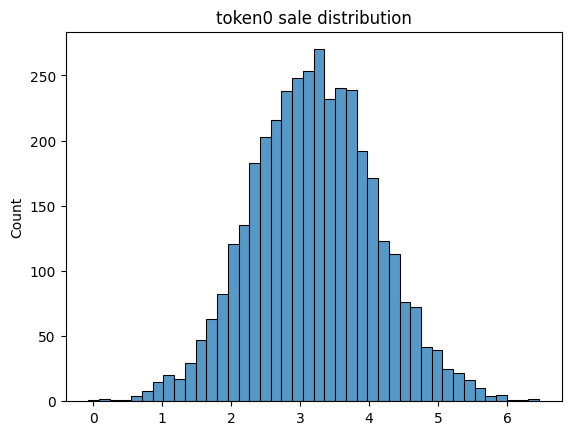

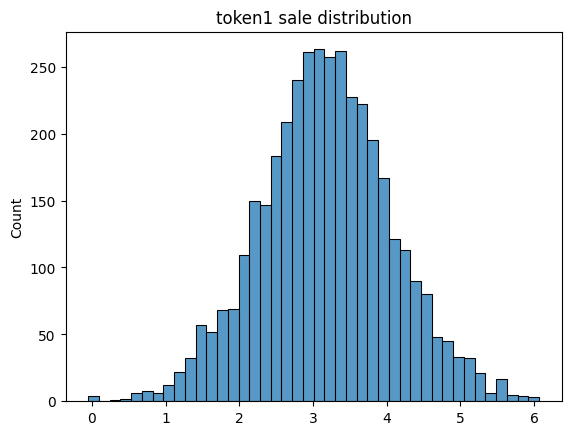

In [537]:
import seaborn as sns
import matplotlib.pyplot as plt

x_ = [item for sublist in create_retail_orders(7200) for item in sublist]
y_ = np.array(x_)[:, 0]
y_ = y_[y_!=0]
sns.histplot(np.log10(y_)); plt.title("token0 sale distribution"); plt.show();

y_ = np.array(x_)[:, 1]
y_ = y_[y_!=0]
sns.histplot(np.log10(y_*1200)); plt.title("token1 sale distribution"); plt.show();

In [546]:
y_ = np.array(x_)[:, 0]
y_ = y_[y_!=0]; print(f"{y_.sum()*.0005:,}")

y_ = np.array(x_)[:, 1]
y_ = y_[y_!=0]; print(f"{y_.sum()*1200*.0005:,}")

261,641.93750154338
384,249,155.87688106


In [539]:
from collections import defaultdict

def make_np_array_duple():
    return np.zeros(shape=2)

class UniV2AMM:
    def __init__(self, L, p, gamma):
        self.gamma = gamma

        self.L = L
        self.p = p
        
        self.lp_fees = defaultdict(make_np_array_duple) # mapping from blockNumber to amount of lp fees for each of token0 and token1
    
    def input_to_get_to_price(self, p1):
        """
        Amount you need to input to get to a price.
        This adjusts for the fee on the input token.
        """
        p0 = self.p
        if p1 < p0:
            return [np.sqrt(self.L)*(np.sqrt(1/p1)-np.sqrt(1/p0)) / (1-self.gamma), 0]
        else:
            return [0, np.sqrt(self.L)*(np.sqrt(p1)-np.sqrt(p0)) / (1-self.gamma)]
    
    def output_to_get_to_price(self, p1):
        """
        Amount you get back by taking the pool to 
        the specified price.
        """
        p0 = self.p
        if p0 < p1:
            return [-np.sqrt(self.L)*(np.sqrt(1/p1)-np.sqrt(1/p0)), 0]
        else:
            return [0, -np.sqrt(self.L)*(np.sqrt(p1)-np.sqrt(p0))]
        
    def avg_exec_price_to_get_to_price(self, p1):
        """
        Gives the avg price of token0 in the execution
        that leads to a pool price of p1.
        Avg price is calculated as
        p_avg = (amount of token1) / (amount of token0).
        """
        
        p0 = self.p
        
        inputs = self.input_to_get_to_price(p1)
        outputs = self.output_to_get_to_price(p1)
        
        if p0 < p1:
            # token0 coming out of the pool
            # price is in units of token1/token0
            return inputs[1]/outputs[0]
        else: # p0 > p1
            # token0 is going into the pool
            return outputs[1]/inputs[0]
        
    def arbitrage_revenue(self, p1):
        """
        Revenue from arbitraging to a true price p1, denoted
        in units of token1.
        
        If p0<p1, we assume that there is a cex transaction
        that sells token0 for token1 at p1, while we place a
        buy of token0 on Uniswap. So the revenue from it is
        
        revenue = (token1 gotten from cex) - (token1 spent on dex)
                = (token0 gotten from dex)*p1 - (token1 spent on dex)
                = (output_to_get_to_price(p1)[0])*p1 - (input_to_get_to_price(p1)[1]).
                
        If p0>p1, we assume that there is a dex transaction
        that sells token0 for token1, and we use a cex to
        buy the amount of token0 needed to do the dex sale.
        
        revenue = (token1 gotten from dex) - (token1 spent on cex)
                = (token1 gotten from dex) - (input_to_get_to_price(p1)[0]*p1)
                = (output_to_get_to_price(p1)[1]) - (input_to_get_to_price(p1)[0]*p1).        
        """
        p0 = self.p
        if p0<p1:
            token1_into_dex = self.input_to_get_to_price(p1)[1]
            token1_from_cex = self.output_to_get_to_price(p1)[0] * p1
            return token1_from_cex-token1_into_dex
        else: # p0>p1
            token1_into_cex = self.input_to_get_to_price(p1)[0]*p1
            token1_from_dex = self.output_to_get_to_price(p1)[1]
            return token1_from_dex-token1_into_cex
        
    def run_arbitrage(self, p1, block_number):
        """
        Perform the state updates necessary for
        running an arbitrage.
        """
        inputs = self.input_to_get_to_price(p1)
                
        # account for LP fees
        self.lp_fees[block_number] += np.array(inputs) * self.gamma
        
        
        # update pool state
        self.p = p1
        
    def sell_token(self, inputs, block_number):
        if inputs[0] == 0:
            delta_y = inputs[1]
            new_price = (delta_y/self.L + np.sqrt(self.p))**2
            self.p = new_price
        if inputs[1] == 0:
            delta_x = inputs[0]
            new_price = (delta_x/self.L + np.sqrt(1/self.p))**(-2)
            self.p = new_price
        
        self.lp_fees[block_number] += np.array(inputs) * self.gamma
        return
    
    def get_price(self):
        return self.p
    
    def get_fees_cumsum_usd(self):
        rough_usd_prices = np.array([
            1,
            1200
        ])
        
        fees_usd = {
            x: self.lp_fees[x] * rough_usd_prices
            for x in self.lp_fees.keys()
        }
        
        cumsum = []
        cur = np.zeros(2)
        for t in range(max(fees_usd.keys())+1):
            cumsum.append(cur + self.lp_fees[t]*rough_usd_prices)
            cur = cumsum[-1]
            
        return cumsum
    
    def simulate(self, true_prices, retail_orders=[], eps=0.004):
        assert true_prices[0] == self.p, "Must start at same price."
        
        n = len(true_prices)
        uni_prices = [self.p] + [0]*(n-1)
        
        for t in range(1, n):
            cur_uni_price = self.p
            if retail_orders!=[]:
                retail_orders_this_block = retail_orders[t]
                for order in retail_orders_this_block:
                    self.sell_token(order, t)
            
            arb_rev = self.arbitrage_revenue(true_prices[t])
            if arb_rev > eps: # then perform the arbitrage
                self.run_arbitrage(true_prices[t], t)
                cur_uni_price = self.get_price()

            uni_prices.append(cur_uni_price)

        return self.get_fees_cumsum_usd()
            
    

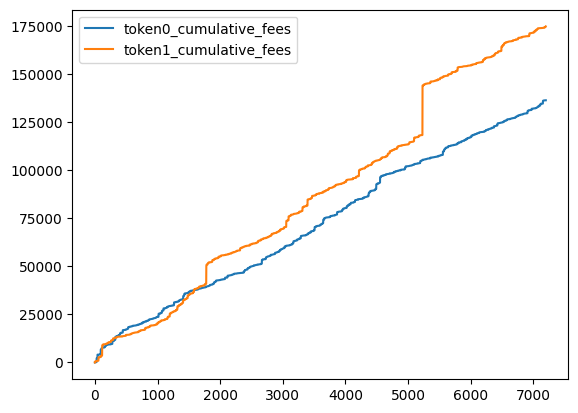

In [544]:
pool_ = UniV2AMM(L=120_000, p=0.0008333333333, gamma=0.003)
x_ = pd.DataFrame(
    pool_.simulate(
        get_price_path(7200, 0, sigma=0.000589255651, s0=pool_.p),
        create_retail_orders(n=7200),
        eps=0.001
    ),
    columns=["token0_cumulative_fees", "token1_cumulative_fees"]
)
x_.plot();

## Values for $\epsilon$

We set $\epsilon$ such that we need the price to cross that percentage. In reality, it would need to be the case that the arbitrage revenue is greater than approx $k=5$ dollars in order to make it worthwhile to arbitrage, otherwise it will be gas-prohibitive. For this to be the case, it must be that $$s\left(\frac{p_t}{p_u} \right) \cdot \left| \sqrt{p_t \cdot p_u} - p_t \right| > k,$$

Where $s$ tells us the size of the arbitrage trade that will get the prices back to parity.